In [3]:
import xarray_beam as xbeam

In [43]:
ds, chunk = xbeam.open_zarr('gcs://gcp-public-data-arco-era5/ar/1959-2022-1h-240x121_equiangular_with_poles_conservative.zarr')
print(chunk)

{'time': 8, 'longitude': 240, 'latitude': 121, 'level': 37}


In [44]:
print(ds.nbytes / 10**9)

14947.185841456


In [63]:
import numpy as np
import pandas as pd

lat_min, lat_max = (20, 50)
lon_min, lon_max = (115, 149)

lat_indices = np.where((ds.latitude >= lat_min) & (ds.latitude <= lat_max))[0]
lon_indices = np.where((ds.longitude >= lon_min) & (ds.longitude <= lon_max))[0]

print(lat_indices)

start_date = pd.to_datetime('2021-12-28')
end_date = pd.to_datetime('2021-12-29')
source_dataset = ds.sel(time=slice(start_date, end_date))
source_dataset = source_dataset.isel(latitude=lat_indices, longitude=lon_indices)
source_dataset = source_dataset.transpose('time', 'latitude', 'longitude', 'level')

print(source_dataset)



[74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]
<xarray.Dataset>
Dimensions:                                           (time: 25, longitude: 23,
                                                       latitude: 20, level: 37)
Coordinates:
  * latitude                                          (latitude) float64 21.0...
  * level                                             (level) int64 1 2 ... 1000
  * longitude                                         (longitude) float64 115...
  * time                                              (time) datetime64[ns] 2...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 ...
    10m_v_component_of_wind                           (time, latitude, longitude) float32 ...
    2m_temperature                                    (time, latitude, longitude) float32 ...
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 ...
    anisotropy_of_sub_gridscal

In [64]:
dataset = source_dataset['land_sea_mask'].values

print(dataset.shape)

(20, 23)


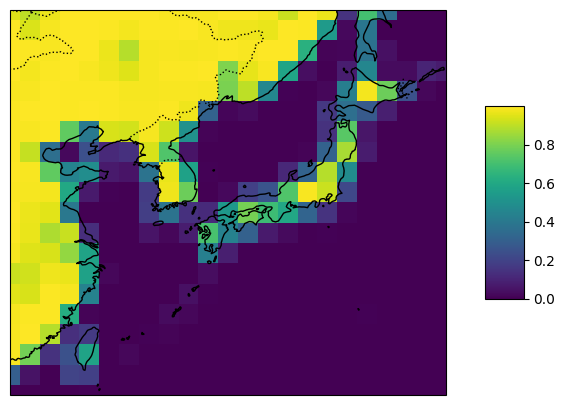

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 예제 NumPy 배열 생성
data = dataset

# 지도 생성 및 데이터 시각화
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 지도에 기본 레이어 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# NumPy 배열을 지도 위에 표시 (임의의 위경도 범위에 맞게 조정)
lons = np.linspace(lon_min, lon_max, data.shape[1])
lats = np.linspace(lat_min, lat_max, data.shape[0])
Lons, Lats = np.meshgrid(lons, lats)
mesh = ax.pcolormesh(Lons, Lats, data, transform=ccrs.PlateCarree())

plt.colorbar(mesh, ax=ax, shrink=0.5, aspect=5)

plt.show()

In [27]:
import torch

def get_tgt_mask(var_len, tgt_time_len) -> torch.tensor:
        matrix = torch.zeros(var_len * tgt_time_len, var_len * tgt_time_len)

        for i in range(tgt_time_len):
            for j in range(var_len):
                inf_idx = min(((i)*var_len), var_len * tgt_time_len)
                matrix[:(i*var_len), inf_idx:] = float('-inf')
        return matrix


print(get_tgt_mask(3, 5))

tensor([[0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,